### Down ảnh về


In [1]:
import json
import requests
import os

# Đọc tệp JSON
with open('all_labeled.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Tạo thư mục local_images nếu chưa có
os.makedirs('local_images', exist_ok=True)

# Khởi tạo danh sách ánh xạ
image_mapping = []

# Duyệt qua từng task trong JSON
for task in data:
    task_id = task['id']
    # Kiểm tra xem task có ảnh không
    if task['data'].get('has_image', 0) == 1:
        images = task['data'].get('images', [])
        # Duyệt qua từng URL ảnh
        for i, url in enumerate(images):
            if url and url.strip():  # Kiểm tra URL không rỗng
                try:
                    # Tải ảnh
                    response = requests.get(url, timeout=10)
                    if response.status_code == 200:
                        # Tạo tên file duy nhất
                        filename = f"local_images/{task_id}_{i}.jpg"
                        # Lưu ảnh vào local
                        with open(filename, 'wb') as f:
                            f.write(response.content)
                        # Thêm vào danh sách ánh xạ
                        image_mapping.append({
                            "task_id": task_id,
                            "original_url": url,
                            "local_path": filename
                        })
                    else:
                        print(f"Lỗi khi tải URL {url} cho task {task_id}: Status code {response.status_code}")
                except Exception as e:
                    print(f"Lỗi khi tải URL {url} cho task {task_id}: {str(e)}")
            else:
                print(f"Bỏ qua URL rỗng cho task {task_id}")

# Lưu tệp ánh xạ
with open('image_mapping.json', 'w', encoding='utf-8') as f:
    json.dump(image_mapping, f, ensure_ascii=False, indent=4)

print("Hoàn tất tải ảnh và tạo tệp ánh xạ!")

KeyboardInterrupt: 

### tiền xử lý và lưu ảnh

Kích thước gốc của local_images/211_0.jpg: (960, 1280)


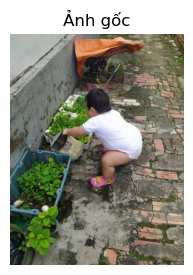

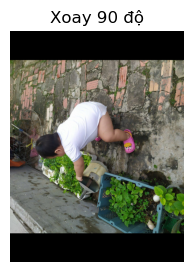

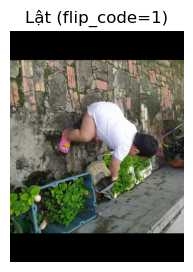

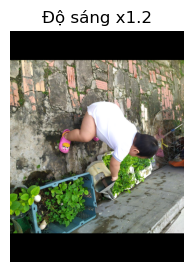

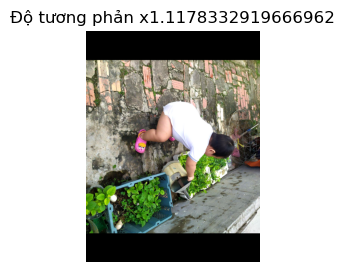

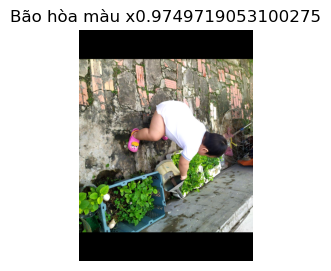

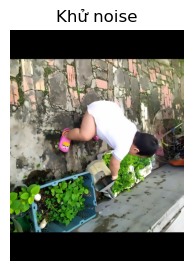

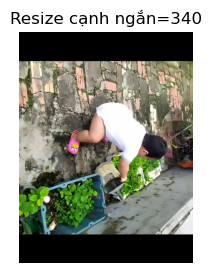

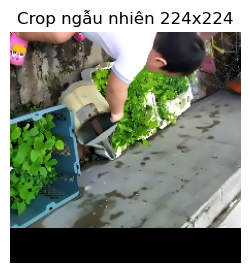

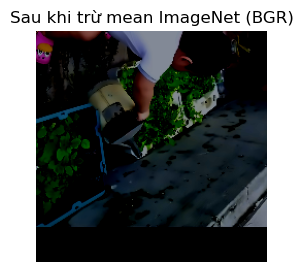

Kích thước gốc của local_images/215_0.jpg: (1440, 1920)
Kích thước gốc của local_images/215_1.jpg: (1440, 1920)
Kích thước gốc của local_images/215_1.jpg: (1440, 1920)
Kích thước gốc của local_images/215_2.jpg: (1440, 1920)
Kích thước gốc của local_images/215_2.jpg: (1440, 1920)
Kích thước gốc của local_images/217_0.jpg: (1500, 1124)
Kích thước gốc của local_images/217_0.jpg: (1500, 1124)
Kích thước gốc của local_images/217_1.jpg: (1124, 1500)
Kích thước gốc của local_images/217_1.jpg: (1124, 1500)
Kích thước gốc của local_images/218_0.jpg: (1080, 498)
Kích thước gốc của local_images/218_0.jpg: (1080, 498)
Kích thước gốc của local_images/224_0.jpg: (1124, 1500)
Kích thước gốc của local_images/224_0.jpg: (1124, 1500)
Kích thước gốc của local_images/228_0.jpg: (1440, 1920)
Kích thước gốc của local_images/228_0.jpg: (1440, 1920)
Kích thước gốc của local_images/228_1.jpg: (1440, 1920)
Kích thước gốc của local_images/228_1.jpg: (1440, 1920)
Kích thước gốc của local_images/228_2.jpg: (1440, 

In [1]:
import json
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

def check_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size  # (width, height)
    except Exception as e:
        raise ValueError(f"Lỗi khi kiểm tra kích thước file {image_path}: {e}")

def show_image(title, img):
    plt.figure(figsize=(3,3))
    plt.imshow(np.clip(img, 0, 1) if img.max() <= 1.0 else img.astype(np.uint8))
    plt.title(title)
    plt.axis('off')
    plt.show()

def adjust_contrast(image, factor):
    mean = np.mean(image, axis=(0,1), keepdims=True)
    return np.clip((image - mean) * factor + mean, 0, 255).astype(np.uint8)

def adjust_saturation(image, factor):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,1] = np.clip(hsv[...,1] * factor, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

def preprocess_image_for_resnet(
    image_path, target_size=(224, 224), 
    rotate_angle=0, flip_code=None, 
    brightness_factor=1.0, denoise=False, visualize=False,
    contrast_factor=None, saturation_factor=None
):
    """
    Tiền xử lý ảnh cho ResNet:
    - Xoay, lật, tăng/giảm độ sáng, khử noise
    - Resize ngẫu nhiên cạnh ngắn hơn trong [256, 480]
    - Crop ngẫu nhiên 224x224 từ ảnh hoặc từ bản lật ngang (nếu flip_code=1)
    - Tăng cường màu sắc: contrast_factor, saturation_factor
    - Trừ mean ImageNet từng kênh BGR: [103.939, 116.779, 123.68]
    - Chuẩn hóa theo mean/std ResNet
    """
    original_size = check_image_size(image_path)
    print(f"Kích thước gốc của {image_path}: {original_size}")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Không thể tải ảnh: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if visualize:
        show_image("Ảnh gốc", image)
    if rotate_angle != 0:
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, rotate_angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
        if visualize:
            show_image(f"Xoay {rotate_angle} độ", image)
    if flip_code is not None:
        image = cv2.flip(image, flip_code)
        if visualize:
            show_image(f"Lật (flip_code={flip_code})", image)
    if brightness_factor != 1.0:
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)
        if visualize:
            show_image(f"Độ sáng x{brightness_factor}", image)
    if contrast_factor is not None and contrast_factor != 1.0:
        image = adjust_contrast(image, contrast_factor)
        if visualize:
            show_image(f"Độ tương phản x{contrast_factor}", image)
    if saturation_factor is not None and saturation_factor != 1.0:
        image = adjust_saturation(image, saturation_factor)
        if visualize:
            show_image(f"Bão hòa màu x{saturation_factor}", image)
    if denoise:
        image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        if visualize:
            show_image("Khử noise", image)
    # Resize ngẫu nhiên cạnh ngắn hơn
    h, w = image.shape[:2]
    rand_short = random.randint(256, 480)
    if h < w:
        new_h = rand_short
        new_w = int(w * (rand_short / h))
    else:
        new_w = rand_short
        new_h = int(h * (rand_short / w))
    image = cv2.resize(image, (new_w, new_h))
    if visualize:
        show_image(f"Resize cạnh ngắn={rand_short}", image)
    # Crop ngẫu nhiên 224x224 từ ảnh hoặc bản lật ngang
    crop_source = image
    if flip_code == 1 and random.random() < 0.5:
        crop_source = cv2.flip(image, 1)
        if visualize:
            show_image("Ảnh lật ngang để crop", crop_source)
    crop_h, crop_w = crop_source.shape[:2]
    if crop_h < 224 or crop_w < 224:
        raise ValueError(f"Ảnh sau resize quá nhỏ để crop 224x224: {crop_h}x{crop_w}")
    y = random.randint(0, crop_h - 224)
    x = random.randint(0, crop_w - 224)
    image = crop_source[y:y+224, x:x+224]
    if visualize:
        show_image("Crop ngẫu nhiên 224x224", image)
    # Trừ mean ImageNet từng kênh BGR
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR).astype(np.float32)
    imagenet_mean = np.array([103.939, 116.779, 123.68])
    image_bgr -= imagenet_mean
    image = cv2.cvtColor(image_bgr.astype(np.float32), cv2.COLOR_BGR2RGB)
    if visualize:
        show_image("Sau khi trừ mean ImageNet (BGR)", np.clip(image/255.0, 0, 1))
    # Chuẩn hóa về [0, 1] và chuẩn hóa theo mean/std ResNet
    image_float = image / 255.0
    original_image = image_float.copy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    processed_image = (image_float - mean) / std
    return processed_image, original_image

def save_processed_image_as_jpeg(image, output_path):
    image = (image * 255.0).astype(np.uint8)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, image_bgr)

def process_and_save_images_to_jpeg(
    mapping_file_path='image_mapping.json', 
    input_dir='local_images', 
    output_dir='processed_images'
):
    os.makedirs(output_dir, exist_ok=True)
    with open(mapping_file_path, 'r', encoding='utf-8') as f:
        image_mapping = json.load(f)
    new_mapping = []
    for idx, entry in enumerate(image_mapping):
        task_id = entry['task_id']
        original_url = entry['original_url']
        local_path = entry['local_path']
        if not os.path.exists(local_path):
            print(f"Ảnh không tồn tại: {local_path}")
            continue
        try:
            visualize = (idx == 0)
            processed_image, original_image = preprocess_image_for_resnet(
                local_path, 
                rotate_angle=90, 
                flip_code=1, 
                brightness_factor=1.2, 
                denoise=True,
                visualize=visualize,
                contrast_factor=random.uniform(0.8, 1.2),
                saturation_factor=random.uniform(0.8, 1.2)
            )
            processed_filename = f"{task_id}_{os.path.basename(local_path).split('.')[0]}.jpeg"
            processed_path = os.path.join(output_dir, processed_filename)
            save_processed_image_as_jpeg(original_image, processed_path)
            new_mapping.append({
                'task_id': task_id,
                'original_url': original_url,
                'local_path': local_path,
                'processed_path': processed_path
            })
        except ValueError as e:
            print(f"Lỗi khi xử lý ảnh {local_path}: {e}")
    with open('new_image_mapping.json', 'w', encoding='utf-8') as f:
        json.dump(new_mapping, f, ensure_ascii=False, indent=4)
    return new_mapping

if __name__ == "__main__":
    new_mapping = process_and_save_images_to_jpeg()
    print(f"Đã xử lý và lưu {len(new_mapping)} ảnh vào thư mục processed_images.")
    print("Tệp ánh xạ mới đã được lưu tại: new_image_mapping.json")